<table>
<tr>
<td>  <img  src="https://raw.githubusercontent.com/Nikoletos-K/pyJedAI/main/documentation/pyjedai.logo.drawio.png?raw=true "style="width: 300px;padding: 40px"/>
</td>
<td> 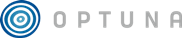 </td>
</tr></table>

# pyJedAI optimization with Optuna

In [1]:
import plotly.express as px
import logging
import sys
import optuna
import plotly
import os
import sys
import pandas as pd
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from optuna.visualization import *

import plotly.io as pio
import plotly.express as px

pio.templates.default = "plotly_white"

## Data Reading

In [2]:
from pyjedai.datamodel import Data

data = Data(
    dataset_1=pd.read_csv("./data/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=pd.read_csv("./data/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=pd.read_csv("./data/D2/gt.csv", sep='|', engine='python'),
)

data.process()

## WorkFlow

In [3]:
from pyjedai.workflow import WorkFlow, compare_workflows
from pyjedai.block_building import StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, ReciprocalWeightedNodePruning, ComparisonPropagation
from pyjedai.matching import EntityMatching
from pyjedai.clustering import ConnectedComponentsClustering

In [4]:
db_name = "pyjedai"
title = "Test"
storage_name = "sqlite:///{}.db".format(db_name)
study_name = title  # Unique identifier of the study.

In [7]:
'''
 OPTUNA objective function
'''
def objective(trial):
    
    w = WorkFlow(
        block_building = dict(
            method=QGramsBlocking, 
            params=dict(qgrams=trial.suggest_int("qgrams", 3, 10)),
            attributes_1=['name'],
            attributes_2=['name']
        ),
        block_cleaning = [
            dict(
                method=BlockPurging,
                params=dict(smoothing_factor=1.025)
            ),
            dict(
                method=BlockFiltering, 
                params=dict(
                    ratio = trial.suggest_float("ratio", 0.7, 0.95)
                )
            )
        ],
        comparison_cleaning = dict(method=CardinalityEdgePruning),
            entity_matching = dict(
            method=EntityMatching, 
            metric='sorensen_dice',
            similarity_threshold= trial.suggest_float("similarity_threshold", 0.05, 0.9),
            attributes = ['description', 'name']
        ),
        clustering = dict(method=ConnectedComponentsClustering),
        name="Worflow-Test"
    )
    w.run(data, verbose=False)
    f1, precision, recall = w.get_final_scores()
    
    return recall

In [8]:
study_name = title  # Unique identifier of the study.
num_of_trials = 30
study = optuna.create_study(
    directions=["maximize"],
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True
)
print("Optuna trials starting")
study.optimize(
    objective, 
    n_trials=num_of_trials, 
    show_progress_bar=True
)
print("Optuna trials finished")

[I 2022-09-26 12:55:34,332] Using an existing study with name 'Test' instead of creating a new one.


Optuna trials starting


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-09-26 12:55:38,611] Trial 1 finished with value: 92.84386617100373 and parameters: {'qgrams': 8, 'ratio': 0.7414379755554323, 'similarity_threshold': 0.23707474956225438}. Best is trial 1 with value: 92.84386617100373.
[I 2022-09-26 12:55:46,779] Trial 2 finished with value: 99.53531598513011 and parameters: {'qgrams': 5, 'ratio': 0.7467879975268619, 'similarity_threshold': 0.25482080793573436}. Best is trial 2 with value: 99.53531598513011.
[I 2022-09-26 12:55:50,652] Trial 3 finished with value: 92.84386617100373 and parameters: {'qgrams': 9, 'ratio': 0.7392219839705335, 'similarity_threshold': 0.07648544734229666}. Best is trial 2 with value: 99.53531598513011.
[I 2022-09-26 12:55:55,499] Trial 4 finished with value: 94.23791821561338 and parameters: {'qgrams': 8, 'ratio': 0.8434811532901894, 'similarity_threshold': 0.14754855534959702}. Best is trial 2 with value: 99.53531598513011.
[I 2022-09-26 12:55:59,645] Trial 5 finished with value: 92.84386617100373 and parameters: {

# Optuna Visualizations

In [ ]:
study.trials_dataframe(attrs=("number", "value", "params", "state"))

In [ ]:
fig = plot_optimization_history(study)
fig.show()

In [ ]:
fig = plot_parallel_coordinate(study)
fig.show()

In [ ]:
fig = plot_parallel_coordinate(study, params=["qgrams"])
fig.show()

In [ ]:
fig = plot_contour(study)
fig.show()

In [ ]:
fig = plot_contour(study, params=["qgrams", "ratio"])
fig.show()

In [ ]:
fig = plot_slice(study,  params=["qgrams", "ratio"])
fig.show()

In [ ]:
fig = plot_slice(study,  params=["qgrams", "ratio"])
fig.show()

In [ ]:
fig = plot_param_importances(study)
fig.show()

In [ ]:
fig = plot_edf(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)
fig.show()